In [96]:
import numpy as np
import pandas as pd
import datetime as dt

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import plotly.express as px
import folium 
import folium.plugins
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import warnings
warnings.filterwarnings("ignore")

In [206]:
dt1 = pd.read_csv('data/trip_data/trip_data_3.csv', nrows=100000)
dt1.drop(columns=' store_and_fwd_flag', inplace=True)
# dt2 = pd.read_csv('data/trip_data/trip_data_2.csv')

df1 = pd.read_csv('data/trip_fare/trip_fare_3.csv', nrows=100000)
# df2 = pd.read_csv('data/trip_fare/trip_fare_2.csv')
df = pd.merge(dt1, df1, how='left', on=['medallion', ' hack_license', ' vendor_id', ' pickup_datetime'])

In [207]:
for i in df.columns:
    df.rename(columns={i : i.strip(' ')}, inplace=True)
df['trip_time'] = df['trip_time_in_secs']/60

In [208]:
coord = ['pickup_longitude','pickup_latitude', 
         'dropoff_longitude', 'dropoff_latitude']

for i in coord :
    df[i] = df[i].replace(0,np.nan)

In [209]:
null_counts = df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

dropoff_longitude    1582
dropoff_latitude     1579
pickup_longitude     1460
pickup_latitude      1453
dtype: int64

In [210]:
df.shape

(100000, 21)

In [211]:
df.dropna(inplace=True)

In [212]:
df.shape

(98402, 21)

In [213]:
# drop observations less than 0 and  greater than 99.9% percentile value.
df = df[(df["fare_amount"] > 0) & (
    df["fare_amount"] < df["fare_amount"].quantile(.999))]

df = df[(df["trip_distance"] > 0) & (
    df["trip_distance"] < df["trip_distance"].quantile(.9999))]

df = df[(df["trip_time_in_secs"] > 0) & (
    df["trip_time_in_secs"] < df["trip_time_in_secs"].quantile(.9999))]

for i in coord:
    df = df[(df[i] > df[i].quantile(.001)) &
            (df[i] < df[i].quantile(.999))]

In [215]:
df.shape

(97307, 21)

In [216]:
pickupTime = pd.to_datetime(df['pickup_datetime'])

df['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
df['dst hourOfDay'] = df['src hourOfDay'] + df['trip_time'] / 60.0

df['dayOfWeek']     = pickupTime.dt.weekday
df['hourOfWeek']    = df['dayOfWeek']*24.0 + df['src hourOfDay']

In [217]:
allLat  = np.array(list(df['pickup_latitude'])  + list(df['dropoff_latitude']))
allLong = np.array(list(df['pickup_longitude']) + list(df['dropoff_longitude']))

In [218]:
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

In [219]:
latMultiplier  * (df['pickup_latitude']   - medianLat)

0       -12.143008
1        -0.243791
2        -3.094919
3         2.209479
4        -0.369471
           ...    
99995    -0.452293
99996     1.619149
99997     5.504329
99998    -2.015449
99999     1.909249
Name: pickup_latitude, Length: 97307, dtype: float64

In [220]:
df['pickup_latitude']

0        40.645164
1        40.752056
2        40.726444
3        40.774094
4        40.750927
           ...    
99995    40.750183
99996    40.768791
99997    40.803692
99998    40.736141
99999    40.771397
Name: pickup_latitude, Length: 97307, dtype: float64

In [221]:
df['src lat']   = latMultiplier  * (df['pickup_latitude']   - medianLat)
df['src long']  = longMultiplier * (df['pickup_longitude']  - medianLong)
df['dst lat']   = latMultiplier  * (df['dropoff_latitude']  - medianLat)
df['dst long']  = longMultiplier * (df['dropoff_longitude'] - medianLong)

allLat  = np.array(list(df['src lat'])  + list(df['dst lat']))
allLong = np.array(list(df['src long']) + list(df['dst long']))

In [222]:
df = df.reset_index(drop=True)

# Basic Plots

In [71]:
px.histogram(df['fare_amount'])

In [73]:
passenger_count         int64
 trip_time_in_secs       int64
 trip_distance

SyntaxError: invalid syntax (3836987161.py, line 1)

In [168]:
px.histogram(df['passenger_count'])

In [223]:
# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("fare_amount", "passenger_count", "trip_distance", "trip_time")
)

# Add traces
fig.add_trace(px.histogram(df['fare_amount'], nbins=len(df))['data'][0], row=1, col=1)
fig.add_vline(x=df['fare_amount'].mean(), line_width=3, line_dash="dash",
              annotation_text="Mean", line_color="green", row=1, col=1)

fig.add_trace(px.histogram(df['passenger_count'])[
              'data'][0], row=1, col=2)
fig.add_vline(x=df['passenger_count'].mean(), line_width=3, line_dash="dash",
              annotation_text="Mean", line_color="green", row=1, col=2)

fig.add_trace(px.histogram(df['trip_distance'], nbins=len(df))[
              'data'][0], row=2, col=1)
fig.add_vline(x=df['trip_distance'].mean(), line_width=3, line_dash="dash",
              annotation_text="Mean", line_color="green", row=2, col=1)

fig.add_trace(px.histogram(df['trip_time'], nbins=len(df))['data'][0], row=2, col=2)
fig.add_vline(x=df['trip_time'].mean(), line_width=3, line_dash="dash",
              annotation_text="Mean", line_color="green", row=2, col=2)

# Update xaxis properties
# fig.update_xaxes(title_text="xaxis 1 title", row=1, col=1)
# fig.update_xaxes(title_text="xaxis 2 title", range=[10, 50], row=1, col=2)
# fig.update_xaxes(title_text="xaxis 3 title", showgrid=False, row=2, col=1)
# fig.update_xaxes(title_text="xaxis 4 title", type="log", row=2, col=2)

# Update yaxis properties
# fig.update_yaxes(title_text="yaxis 1 title", row=1, col=1)
# fig.update_yaxes(title_text="yaxis 2 title", range=[40, 80], row=1, col=2)
# fig.update_yaxes(title_text="yaxis 3 title", showgrid=False, row=2, col=1)
# fig.update_yaxes(title_text="yaxis 4 title", row=2, col=2)

# Update title and height
fig.update_layout(showlegend=False,
                  title_text="Customizing Subplot Axes", height=700)


fig.show()

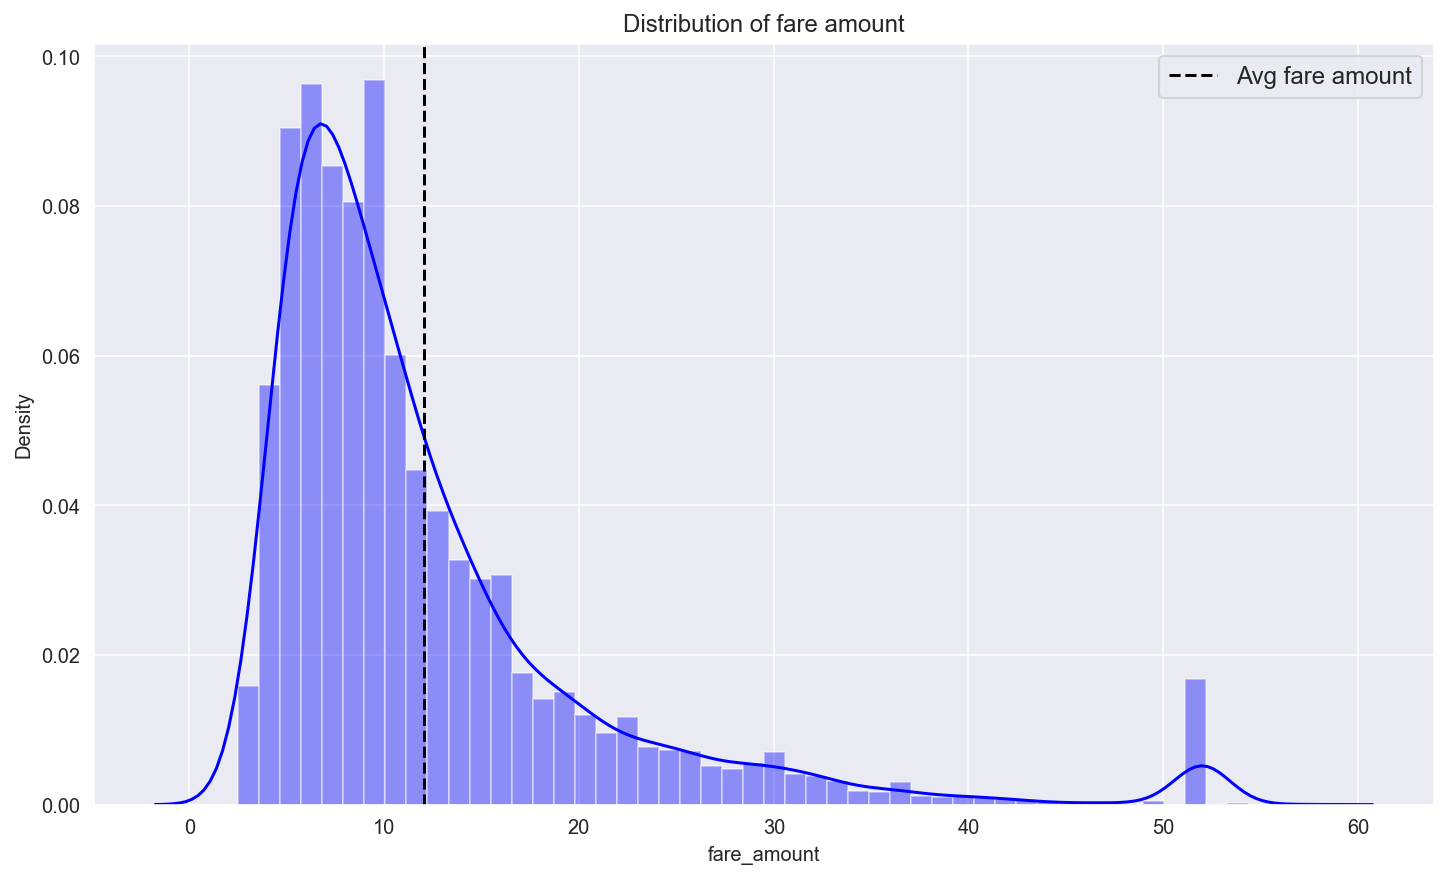

In [182]:
plt.figure(figsize = (12,7))
sns.distplot(df["fare_amount"],color = "b")
plt.axvline(df["fare_amount"].mean(),color = "k",
            linestyle = "dashed",label = "Avg fare amount")
plt.title("Distribution of fare amount")
plt.legend(loc = "best",prop = {"size" : 12})
plt.show()

In [191]:
px.scatter(x=df["fare_amount"], y=df["trip_distance"])

rate code is 2 are charged 52